# Augmented Convolutional Neural Network capable of testing

---



---



In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
#Preprocess cats_vs_dogs images
totalSet = tfds.load('cats_vs_dogs', split='train', shuffle_files=True)
#final image size
IMG_SIZE = 100
#resize and rescale images function
resize_and_rescale =  tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
])
#loop through
trainX = []
trainY = []
i = 0
for example in totalSet:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  #resize images
  i += 1
  trainX.append(np.array(resize_and_rescale(example['image'])))
  trainY.append(np.array(example['label']))


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete95EC70/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#set as arrays
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)
#split data into validation and training
val_x = trainX[:1000]
partial_x = trainX[1000:]
val_y = trainY[:1000]
partial_y = trainY[1000:]

#reshape training data
data_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest')
data_gen.fit(partial_x)
partial_data = data_gen.flow(partial_x, partial_y, batch_size=32)

#reshape validation data
val_datagen = ImageDataGenerator(rescale=1)
val_datagen.fit(val_x)
val_data = data_gen.flow(val_x, val_y, batch_size=32)

In [4]:
#impliment and develop Model
from keras import models
from keras import layers
from keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3

#import VGG16 
conv_base = InceptionV3(weights='imagenet',
include_top=False,
input_shape=(100 , 100, 3))

#sequential convolutional neural network model
network = models.Sequential()
network.add(conv_base)
network.add(layers.Flatten())
network.add(layers.Dense(1024))
network.add(layers.LeakyReLU())
network.add(layers.Dropout(0.2))
network.add(layers.Dense(1,activation='sigmoid'))

network.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

#fit
history = network.fit(partial_data,steps_per_epoch=len(partial_x) / 32,epochs=100,validation_data=val_data, validation_steps= len(val_x)/32)


Epoch 1/100
696/695 [==============================] - 58s 84ms/step - loss: 0.8318 - accuracy: 0.6379 - val_loss: 12.7224 - val_accuracy: 0.6510
Epoch 2/100
696/695 [==============================] - 56s 81ms/step - loss: 0.4666 - accuracy: 0.7881 - val_loss: 1.3426 - val_accuracy: 0.6980
Epoch 3/100
696/695 [==============================] - 56s 80ms/step - loss: 0.3474 - accuracy: 0.8491 - val_loss: 0.4505 - val_accuracy: 0.8120
Epoch 4/100
696/695 [==============================] - 56s 80ms/step - loss: 0.3079 - accuracy: 0.8706 - val_loss: 0.3058 - val_accuracy: 0.8860
Epoch 5/100
696/695 [==============================] - 56s 81ms/step - loss: 0.2749 - accuracy: 0.8912 - val_loss: 0.2385 - val_accuracy: 0.9000
Epoch 6/100
696/695 [==============================] - 56s 81ms/step - loss: 0.2551 - accuracy: 0.8959 - val_loss: 0.2559 - val_accuracy: 0.9120
Epoch 7/100
696/695 [==============================] - 56s 81ms/step - loss: 0.2430 - accuracy: 0.9033 - val_loss: 0.2714 - val_a

0.9589999914169312


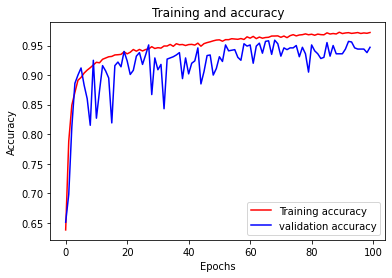

In [5]:
#show loss and accuracy
from matplotlib import pyplot
#get loss for training
acc = np.asarray(history.history['accuracy'])
#get loss for testing
val_acc = np.asarray(history.history['val_accuracy'])
# x axis will display epochs running from 1 to the number of losses we have  - 1
epochs = np.asarray(range(len(acc)))
pyplot.plot(epochs,acc,'r',label='Training accuracy')
pyplot.plot(epochs,val_acc,'b',label='validation accuracy')
pyplot.title('Training and accuracy')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.legend()
print(max(val_acc))
pyplot.show()


In [ ]:
#Test Image
from keras.preprocessing import image
name = 'cat.jpg'
instance = image.load_img(name, target_size = (64,64))
instance = image.img_to_array(instance)
instance = np.array(resize_and_rescale(instance))

#test on network
answer = network.predict(np.asarray([instance]))
if answer[0][0] >= 0.5:
  print("We have classified it as a dog")
else:
  print("We have classified it as a cat")